In [ ]:
!pip install hatesonar

In [361]:
import json

In [271]:
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from LoadingData import LoadingData
import numpy as np

import nltk
nltk.download('punkt')
from nltk import word_tokenize

from hatesonar import Sonar


In [272]:
def clean_getty_data():
    data = LoadingData.LoadingData("~/projects/Hateful_Memes_Project/data/getty_data_full.csv")
    getty=data.load_data()
    df=getty[~getty['image'].str.contains("\(")]
    getty[~getty['image'].str.contains("\(")].image.nunique()
    
    df['color_zscore'] = (df['Color_Score'] - df['Color_Score'].mean())/df['Color_Score'].std(ddof=0)
    df['key_point_zscore'] = (df['Key_Point_Score'] - df['Key_Point_Score'].mean())/df['Key_Point_Score'].std(ddof=0)
    df['combined_z']=df['color_zscore']+df['key_point_zscore']
    df['combined_zscore']=(df['combined_z'] - df['combined_z'].mean())/df['combined_z'].std(ddof=0)
    
#     s = df.combined_zscore
#     ax = s.plot.kde()
#     display(df.combined_zscore.describe())
    
    combined_index = df.groupby('image')['combined_zscore'].idxmin()
    match=df.loc[combined_index]
    
    return match

In [273]:
def load_full_dataset():
    df_list = []

    for x in ['train','dev','test']:
        file="../data/"+x+".jsonl"
        data=LoadingData.LoadingData(file)
        data_json=data.load_data()
        df=pd.DataFrame(data_json)
        df['partition']=x
        if x=='test':
            df['label']=np.nan
        df_list.append(df)
    
    final = pd.concat(df_list)
    return final
    
    

In [346]:
def create_meme_text_hate_speech_features(clean):
    sonar = Sonar()
    clean['hate_speech']=clean.text.apply(lambda x: sonar.ping(text=str(x or '')).get('classes')[0].get('confidence'))
    clean['offensive_langauge']=clean.text.apply(lambda x: sonar.ping(text=str(x or '')).get('classes')[1].get('confidence'))
    clean['neither']=clean.text.apply(lambda x: sonar.ping(text=str(x or '')).get('classes')[2].get('confidence'))

In [357]:
def create_simple_getty_features():
    #load data.  Match is best matching Getty data and df is full dataframe of train/test/dev data
    match=clean_getty_data()
    df=load_full_dataset()
    
    
    #clean up types, column names, and text
    match['src']=match['src'].astype(str)
    df['id']=df['id'].astype(str)
    match.rename(columns={'id':'rank'}, inplace=True)
    
    full=df.merge(match, how='left', left_on='id', right_on='src')
    full['tags_clean']= full['tags'].str.replace(',',' ').str.replace('Photos',' ').str.lower().str.split()
    
    #tokenize text
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    full['text_clean'] = full['text'].apply(lambda x: tokenizer.tokenize(x))
    
    
    clean=full[['id','img','text','text_clean','partition','tags','tags_clean','caption','combined_zscore','label']]
    
    #calculate text frequencies
    clean['all_text_freq']= clean.text.map(clean.text.value_counts())
    clean['train_text_freq']= clean.text.map(clean[clean.partition=='train'].text.value_counts())
    clean['dev_text_freq']= clean.text.map(clean[clean.partition=='dev'].text.value_counts())
    clean['test_text_freq']= clean.text.map(clean[clean.partition=='test'].text.value_counts())

    # manual lists for features.  This snowballed into something ugly, refactor in a better way, maybe dict.
    race=['african','black','asian','chinese','arab','white','african-american','ethnicity']
    disability=['disabled','disability',"down's, syndrome",'retarded','retarted']
    religion=['islam','muslim','muslims','catholic','catholics','christian','christians','jewish','jew','jews',
             'god','jesus']
    sexual_orientation=['gay','straight','trans','transexual','homo','homosexual']
    violence=['obscene','anger','aggression','kill','killing','bomb','gun']

    criminals=['hitler']
    animals=['alligator','ant','bear','bee','bird','camel','cat','cheetah','chicken','chimpanzee','cow','crocodile','deer','dog','dolphin','duck','eagle','elephant','fish','fly','fox','frog','giraffe','goat','goldfish','hamster','hippopotamus','horse','kangaroo','kitten','lion','lobster','monkey','octopus','owl','panda','pig','puppy','rabbit','rat','scorpion','seal','shark','sheep','snail','snake','spider','squirrel','tiger','turtle','wolf','zebra']

    gender=['man','woman','men','women','bitch','pussy']

    #simple features for baseline
    clean['tags_clean'] = [ [] if x is np.NaN else x for x in clean['tags_clean'] ]
    clean['tags_race'] = clean.apply(lambda row: True if any(item in race for item in row['tags_clean']) else False, axis = 1)
    clean['tags_disability'] = clean.apply(lambda row: True if any(item in disability for item in row['tags_clean']) else False, axis = 1)
    clean['tags_religion'] = clean.apply(lambda row: True if any(item in religion for item in row['tags_clean']) else False, axis = 1)
    clean['tags_sexual_orientation'] = clean.apply(lambda row: True if any(item in sexual_orientation for item in row['tags_clean']) else False, axis = 1)
    clean['tags_violence'] = clean.apply(lambda row: True if any(item in violence for item in row['tags_clean']) else False, axis = 1)
    clean['tags_criminals'] = clean.apply(lambda row: True if any(item in criminals for item in row['tags_clean']) else False, axis = 1)
    clean['tags_gender'] = clean.apply(lambda row: True if any(item in gender for item in row['tags_clean']) else False, axis = 1)
    clean['tags_animals'] = clean.apply(lambda row: True if any(item in animals for item in row['tags_clean']) else False, axis = 1)

    clean['text_clean'] = [ [] if x is np.NaN else x for x in clean['text_clean'] ]
    clean['text_race'] = clean.apply(lambda row: True if any(item in race for item in row['text_clean']) else False, axis = 1)
    clean['text_disability'] = clean.apply(lambda row: True if any(item in disability for item in row['text_clean']) else False, axis = 1)
    clean['text_religion'] = clean.apply(lambda row: True if any(item in religion for item in row['text_clean']) else False, axis = 1)
    clean['text_sexual_orientation'] = clean.apply(lambda row: True if any(item in sexual_orientation for item in row['text_clean']) else False, axis = 1)
    clean['text_violence'] = clean.apply(lambda row: True if any(item in violence for item in row['text_clean']) else False, axis = 1)
    clean['text_criminals'] = clean.apply(lambda row: True if any(item in criminals for item in row['text_clean']) else False, axis = 1)
    clean['text_gender'] = clean.apply(lambda row: True if any(item in gender for item in row['text_clean']) else False, axis = 1)
    clean['text_animals'] = clean.apply(lambda row: True if any(item in animals for item in row['text_clean']) else False, axis = 1)
    
    #Add hate speech features
    create_meme_text_hate_speech_features(clean)
    
    return clean

In [371]:
clean=create_simple_getty_features()

/Users/forrest.xiao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/forrest.xiao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/forrest.xiao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [372]:
clean.to_csv( "../data/getty_features.csv", index=False)

### Simple Decision Tree Model

In [373]:
clean.head(1)

,id,img,text,text_clean,partition,tags,tags_clean,caption,combined_zscore,label,...,text_disability,text_religion,text_sexual_orientation,text_violence,text_criminals,text_gender,text_animals,hate_speech,offensive_langauge,neither
0,42953,img/42953.png,its their character not their color that matters,"[its, their, character, not, their, color, that, matters]",train,"Men Photos,African Ethnicity Photos,Fashion Model Photos,Only Men Photos,Completely Bald Photos,Handsome People Photos,Low Key Photos,Portrait Photos,Shiny Photos,Beautiful People Photos,Black Bac...","[men, african, ethnicity, fashion, model, only, men, completely, bald, handsome, people, low, key, portrait, shiny, beautiful, people, black, background, 30-39, years, adult, adults, only, brown, ...",A studio portrait in profile of a handsome young man.,-0.889132,0.0,...,False,False,False,False,False,False,False,0.033328,0.360798,0.605875


In [374]:
clean.columns

Index(['id', 'img', 'text', 'text_clean', 'partition', 'tags', 'tags_clean',
       'caption', 'combined_zscore', 'label', 'all_text_freq',
       'train_text_freq', 'dev_text_freq', 'test_text_freq', 'tags_race',
       'tags_disability', 'tags_religion', 'tags_sexual_orientation',
       'tags_violence', 'tags_criminals', 'tags_gender', 'tags_animals',
       'text_race', 'text_disability', 'text_religion',
       'text_sexual_orientation', 'text_violence', 'text_criminals',
       'text_gender', 'text_animals', 'hate_speech', 'offensive_langauge',
       'neither'],
      dtype='object')

In [375]:
clean.combined_zscore.fillna(2, inplace=True)
# clean.all_text_freq.fillna(0, inplace=True)
# clean.train_text_freq.fillna(0, inplace=True)
# clean.dev_text_freq.fillna(0, inplace=True)

In [377]:
features=clean.columns[14:].tolist()
# features.append('combined_zscore')
# features=clean.columns[13:].tolist()
# cols.append('id')
# cols.append('label')
features

['tags_race',
 'tags_disability',
 'tags_religion',
 'tags_sexual_orientation',
 'tags_violence',
 'tags_criminals',
 'tags_gender',
 'tags_animals',
 'text_race',
 'text_disability',
 'text_religion',
 'text_sexual_orientation',
 'text_violence',
 'text_criminals',
 'text_gender',
 'text_animals',
 'hate_speech',
 'offensive_langauge',
 'neither']

In [378]:
X = clean[clean.partition=='train'][features]
y = clean[clean.partition=='train'].label

In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70% training and 30% test

In [380]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [381]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [382]:
from sklearn.metrics import roc_auc_score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("AUC:",roc_auc_score(y_test, y_pred))

Accuracy: 0.6411764705882353
AUC: 0.588046097417443


In [383]:
y_test.value_counts()

0.0    1091
1.0     609
Name: label, dtype: int64

In [384]:
from sklearn.metrics import confusion_matrix

c=confusion_matrix(y_test, y_pred)
c / c.astype(np.float).sum(axis=1)

array([[0.77543538, 0.40229885],
       [0.33455545, 0.40065681]])

In [385]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74      1091
         1.0       0.50      0.40      0.44       609

    accuracy                           0.64      1700
   macro avg       0.60      0.59      0.59      1700
weighted avg       0.63      0.64      0.63      1700



No handles with labels found to put in legend.


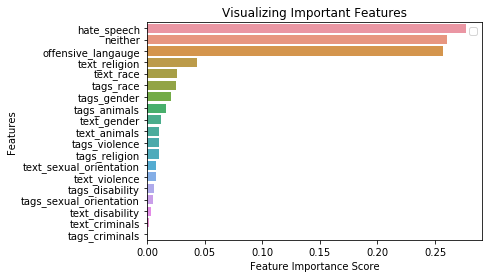

In [386]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [169]:
X_train.head()

,tags_race,tags_disability,tags_religion,tags_sexual_orientation,tags_violence,tags_criminals,tags_gender,tags_animals,text_race,text_disability,text_religion,text_sexual_orientation,text_violence,text_criminals,text_gender,text_animals
2157,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
6048,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3342,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3500,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8433,True,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False


### Nice Illustration of "comparison to animal" hate speech category

In [315]:
clean[clean.text=='sea monkeys'].head()

,id,img,text,partition,tags,caption,combined_zscore,label
1140,82940,img/82940.png,sea monkeys,train,"Affectionate Photos,Animal Photos,Animal Themes Photos,Staring Photos,Animal Behaviour Photos,Animal Family Photos,Animal Hair Photos,Animals In The Wild Photos,Beauty In Nature Photos,Cold Temper...",NaN,0.159783,0.0
1438,16298,img/16298.png,sea monkeys,train,"Monkey Photos,Thailand Photos,No People Photos,Sea Photos,Island Photos,Beach Photos,Portrait Photos,Animal Themes Photos,Animals In The Wild Photos,Colour Image Photos,Day Photos,Focus On Foregro...",NaN,-1.013600,0.0
1545,75209,img/75209.png,sea monkeys,train,"Underwater Photos,Child Photos,Swimming Photos,4-5 Years Photos,6-7 Years Photos,8-9 Years Photos,African-American Ethnicity Photos,Below Photos,Boys Photos,Brother Photos,Carrying Photos,Cheerful...",NaN,-0.640952,1.0
1853,89123,img/89123.png,sea monkeys,train,"Africa Photos,African Ethnicity Photos,Beach Photos,Beach Holiday Photos,Boys Photos,Carefree Photos,Casual Clothing Photos,Cheerful Photos,Child Photos,Childhood Photos,Children Only Photos,Colou...","Kids having fun run splashing sea water in Zanzibar, Tanzania",-0.782410,1.0
2284,1578,img/01578.png,sea monkeys,train,"Beach Photos,Beautiful People Photos,People Photos,Friendship Photos,Beauty Photos,Sunglasses Photos,Adult,Fun Photos,Sunlight Photos,Swimming Shorts Photos,Water Photos,Wellbeing Photos,Group Of ...",NaN,-0.197357,1.0


In [316]:
### features needed:
# image_has_animal
# image_has_person
# image_has_criminal
# image_has_race
# image_has_religion

/Users/forrest.xiao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/forrest.xiao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/forrest.xiao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [324]:
clean[~clean.test_text_freq.isna()].all_text_freq.value_counts()

2     586
1     505
4      40
3      39
5      20
17     17
9       9
8       8
6       6
Name: all_text_freq, dtype: int64

In [330]:
clean[(clean.test_text_freq==clean.all_text_freq)&(~clean.test_text_freq.isna())].head()

,id,img,text,partition,tags,caption,combined_zscore,label,all_text_freq,train_text_freq,dev_text_freq,test_text_freq
9001,37405,img/37405.png,introducing fidget spinner for women,test,"Amstel River Photos,Amsterdam Photos,Arch Photos,Arch Bridge Photos,Architecture Photos,Autumn Photos,Beauty Photos,Black And White Photos,Brick Photos,Brick House Photos,Bridge - Built Structure ...",This picture was taken early in the morning in the canals of Amsterdam. With no boats yet moving on the canals and little wind the reflections are almost perfect.,-0.411643,NaN,1,NaN,NaN,1.0
9004,97015,img/97015.png,finds out those 72 virgins.. are goats,test,"Lifestyles Photos,South Africa Photos,18-19 Years Photos,20-24 Years Photos,Adult,Adults Only Photos,African-American Ethnicity Photos,Beautiful Woman Photos,Black Hair Photos,Bonding Photos,Boyfr...",Close-up portrait of smiling young friends against red wall,-0.569346,NaN,1,NaN,NaN,1.0
9008,69421,img/69421.png,when they laugh about your 9cm in the change room but they haven't seen your 9 mm yet,test,"35-39 Years Photos,45-49 Years Photos,55-59 Years Photos,Adult,Adults Only Photos,Business Photos,Business Finance and Industry Photos,Business Person Photos,Businessman Photos,Businesswoman Photo...",NaN,-0.706481,NaN,1,NaN,NaN,1.0
9009,50162,img/50162.png,"roses are black, violets are black everything is black, i can't see",test,"Drum Kit Photos,Guitar Photos,Performance Group Photos,Person in Education Photos,Rehearsal Photos,Singing Photos,Acoustic Guitar Photos,Adult,Adults Only Photos,Amplifier Photos,Arts Culture and ...","Group of friends practicing as a band, before the performance in the club.",-1.016602,NaN,1,NaN,NaN,1.0
9011,75081,img/75081.png,myth: gingers don't have souls fact: gingers earn a freckle for everey soul they steal,test,"20-29 Years Photos,Achievement Photos,Adult,Adults Only Photos,African-American Ethnicity Photos,Aspirations Photos,Beautiful Woman Photos,Business Photos,Business Person Photos,Businesswear Photo...",Portrait of a young woman standing in an office with colleagues in the background,-0.931846,NaN,1,NaN,NaN,1.0


In [332]:
clean[clean.text=="doesn't wear tampons because she trips over the string"]

,id,img,text,partition,tags,caption,combined_zscore,label,all_text_freq,train_text_freq,dev_text_freq,test_text_freq
37,51846,img/51846.png,doesn't wear tampons because she trips over the string,train,"Animal Themes Photos,Animals In The Wild Photos,Arthropod Photos,Beauty In Nature Photos,Bee Photos,Close-Up Photos,Colony Photos,Colour Image Photos,Day Photos,Drop Photos,Elevated View Photos,Fl...",NaN,0.344539,0.0,2,1.0,NaN,1.0
9076,28396,img/28396.png,doesn't wear tampons because she trips over the string,test,"Seductive Women Photos,Women Photos,Beautiful Woman Photos,Outdoors Photos,Sensuality Photos,20-24 Years Photos,Adult,Adults Only Photos,Arms Raised Photos,Beautiful People Photos,Beauty Photos,Bi...",NaN,-0.544217,NaN,2,1.0,NaN,1.0


In [331]:
clean[(clean.test_text_freq!=clean.all_text_freq)&(~clean.test_text_freq.isna())].head()

,id,img,text,partition,tags,caption,combined_zscore,label,all_text_freq,train_text_freq,dev_text_freq,test_text_freq
37,51846,img/51846.png,doesn't wear tampons because she trips over the string,train,"Animal Themes Photos,Animals In The Wild Photos,Arthropod Photos,Beauty In Nature Photos,Bee Photos,Close-Up Photos,Colony Photos,Colour Image Photos,Day Photos,Drop Photos,Elevated View Photos,Fl...",NaN,0.344539,0.0,2,1.0,NaN,1.0
73,12548,img/12548.png,running chocolate,train,"Dining Photos,Evening Meal Photos,Garden Party Photos,No People Photos,Outdoors Photos,Preparation Photos,Summer Photos,Wine Bottle Photos,Absence Photos,Anticipation Photos,Arrangement Photos,Bee...",NaN,-0.577300,0.0,2,1.0,NaN,1.0
95,18350,img/18350.png,when you see the gas bill,train,"One Woman Only Photos,Paper Photos,Holding Photos,Shock,Reading Photos,Confusion Photos,Financial Bill Photos,Frustration Photos,Manager Photos,Letter Photos,Mature Adult Photos,Studio Shot Photos...",Shocking caucasian adult woman holding paper sheets and is surprised.,-0.395161,0.0,4,2.0,NaN,2.0
161,28793,img/28793.png,congratulations it's non binary,train,"Active Lifestyle Photos,Adult,Adults Only Photos,African Ethnicity Photos,African-American Ethnicity Photos,Athlete Photos,Bodyweight Training Photos,Brazilian Ethnicity Photos,Bridge - Built Stru...",fit man man working out,-0.223013,0.0,2,1.0,NaN,1.0
182,61952,img/61952.png,what i say about the gunman every time there's a mass shooting,train,"Blonde Hair Photos,Excitement Photos,One Person Photos,One Woman Only Photos,One Young Woman Only Photos,Surprise Photos,Women Photos,20-29 Years Photos,Adult,Adults Only Photos,Arms Raised Photos...",NaN,-1.133127,0.0,4,3.0,NaN,1.0
